# Dog breed classification 

This notebook is about using CNN transfer learning to identify Dog breeds


# Dataset Description

The dataset that we will use is from <a href="https://www.kaggle.com/competitions/dog-breed-identification/overview"> kaggle's dog breed identification Competition</a>

The dataset contains a subset of imagenet pictures of dogs and a total of 120 breeds. There are around 10.2k images in the train set and 10.4k in the test set. For this project we will stick to the 10.2k training images as our initial dataset(to be cut down later)  and we will use the provided labels.csv file to get our classes/labels for these images

# Task description

The task for this project is given an image of a dog , classify it to a specify class/breed

# Imports

the required imports are:
* numpy
* cv2
* pandas
* collections
* matplotlib
* random
* sklearn
* keras
* keras_tuner
* tensorflow.keras

In [98]:
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm
from matplotlib import pyplot as plt
from random import *
#imports for image reading\n",
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
#imports for label encoding for classes\n",
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,Flatten,GlobalMaxPooling2D
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras import callbacks
import keras_tuner as kt

# Exploratory Data Analysis

In this part of the notebook, we will be performing Exploratory Data Analysis on the labels of each instance. 


The first thing that we did here is check on the contents of the csv file as a whole and analyze the kind of data that we will be working with with regards to our model.

In [99]:
data = pd.read_csv('labels.csv')
data

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


Upon inspection, we can see that the csv file contains both the ID of each specific instance and the breed of the instance. It is noted that the ID of the data instance is also the name of the image of the same instance, concatenated with a JPEG extension at the end (JPEG). Because we will be both loading the images via their image name and removing certain rows during data preprocessing thereby removing the indexes as well, we will be keeping this column along with the breed column for later access.

Next, we would be exploring the total instances of each dog breed found within the data, as well as the spread of the class instances. This is important because this will serve as the deciding factor for how we will be shortening our data later on. Right now, our intention is to shorten the data such that the resulting shortened data would become as evenly distributed in terms of classes as possible.

In [100]:
data_plot = data.groupby('breed')['id'].count().sort_values()
data_plot.head(50)

breed
briard                            66
eskimo_dog                        66
komondor                          67
brabancon_griffon                 67
golden_retriever                  67
german_shepherd                   69
walker_hound                      69
giant_schnauzer                   69
tibetan_mastiff                   69
otterhound                        69
vizsla                            70
french_bulldog                    70
soft-coated_wheaten_terrier       71
chihuahua                         71
kuvasz                            71
standard_schnauzer                72
border_collie                     72
flat-coated_retriever             72
curly-coated_retriever            72
redbone                           72
malinois                          73
brittany_spaniel                  73
cocker_spaniel                    74
doberman                          74
american_staffordshire_terrier    74
english_springer                  75
pekinese                        

<AxesSubplot:title={'center':'Count Per Breed'}, ylabel='breed'>

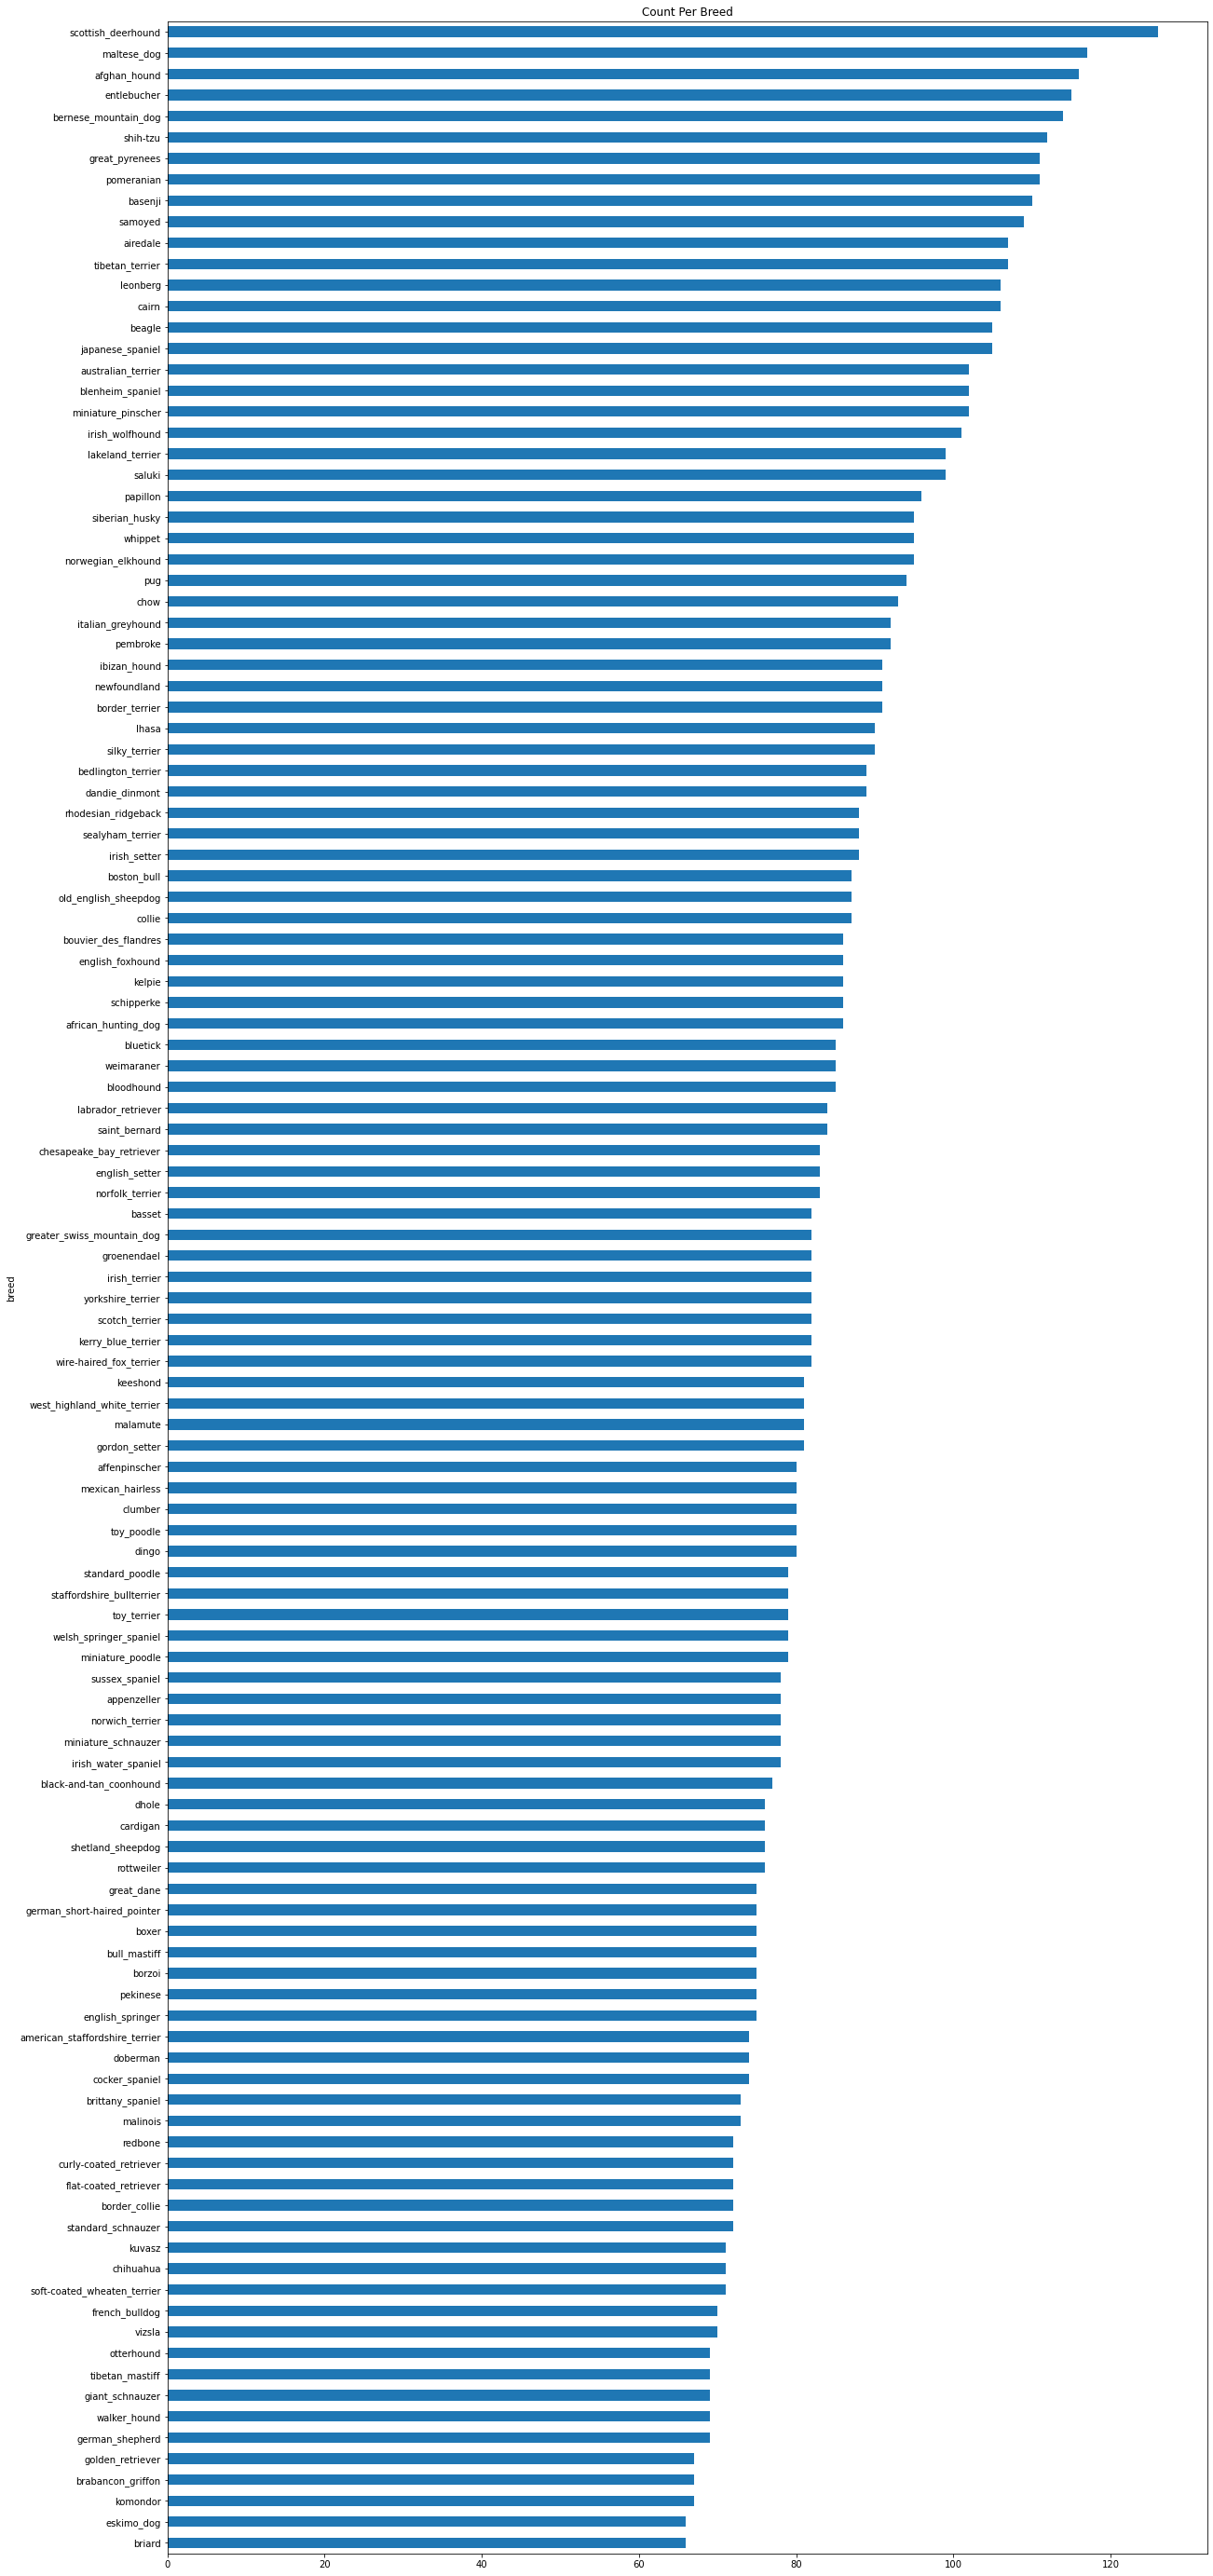

In [101]:
data_plot.plot(kind = 'barh', figsize=(20,50), title="Count Per Breed")

In [102]:
data_plot.describe()

count    120.000000
mean      85.183333
std       13.298122
min       66.000000
25%       75.000000
50%       82.000000
75%       91.250000
max      126.000000
Name: id, dtype: float64

It would also be a prudent idea to examine the images that we have our data, even without actually loading all of it yet onto the Notebook, a part that will be handled during Data Preprocessing. We can do this using the `imread` function imported from cv2 and use it to read any random image that can be found within our `train/` folder.

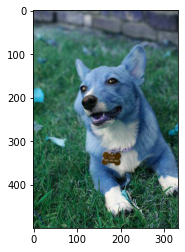

In [103]:
ind = randint(0,data.shape[0])
img_name = 'train/' + data['id'][ind] + ".jpg"
img = cv2.imread(img_name)
plt.imshow(img)

The primary takeaways from the exploratory cells above are the following: <br>
- 120 different dog breeds present in the data.
- The number of breed instances can range from as low as 66 to as high as 126.
- The values of each dog breed deviate fairly consistently with each other, with each value incrementing one at a time. The only major exception is the highest value (126), which is 9 values off of the 2nd highest (117).
- The images used for the data have varying degrees of visibility of the dog, with some images featuring the dog only as a small segment within it. 
- The sizes of the images highly vary, both in terms of length and in terms of width.

- Many of the different dog breed are actually part of a single parent breed where it can be lumped together. This parent breed is usually the last word of the name of the dog breed. An example is how blenheim_spaniel, japanese_spaniel, and irish_water_spaniel can all be lumped together into one parent breed: "spaniel"

It is that final bullet point in particular that motivates us to continue exploring the data, but this time for each parent breed. What we want now is to check the data and value count for each parent breed. We will start by checking specific parent breeds one by one, and then check them as a whole.

<h3> Terrier

In [104]:
terrier = data[data['breed'].str.contains('terrier')]
terrier

,id,breed
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
14,0075dc49dab4024d12fafe67074d8a81,norfolk_terrier
16,007b5a16db9d9ff9d7ad39982703e429,wire-haired_fox_terrier
18,007ff9a78eba2aebb558afea3a51c469,lakeland_terrier
...,...,...
10192,ff4afeb51a1473f7ba18669a8ff48bc9,border_terrier
10194,ff52a3909f5801a71161cec95d213107,west_highland_white_terrier
10201,ff84992beff3edd99b72718bec9448d2,bedlington_terrier
10202,ff8e3fa7e04faca99af85195507ee54d,sealyham_terrier


In [105]:
terrier['breed'].value_counts()

tibetan_terrier                   107
australian_terrier                102
lakeland_terrier                   99
border_terrier                     91
silky_terrier                      90
bedlington_terrier                 89
sealyham_terrier                   88
norfolk_terrier                    83
irish_terrier                      82
wire-haired_fox_terrier            82
kerry_blue_terrier                 82
yorkshire_terrier                  82
scotch_terrier                     82
west_highland_white_terrier        81
toy_terrier                        79
staffordshire_bullterrier          79
norwich_terrier                    78
american_staffordshire_terrier     74
soft-coated_wheaten_terrier        71
Name: breed, dtype: int64

In [106]:
terrier.shape

(1621, 2)

<h3> Retriever

In [107]:
retriever = data[data['breed'].str.contains('retriever')]
retriever

,id,breed
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
25,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
31,00cc68a50b2d016a6b29af628ea4e04b,labrador_retriever
37,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever
127,02ff77af410e966b7b661f6f0789d947,golden_retriever
...,...,...
10134,fdc614c16f54555064a32bc94522b4a4,curly-coated_retriever
10172,febcab8eb2da444bf83336cffec7eb92,golden_retriever
10182,ff05f3976c17fef275cc0306965b3fe4,labrador_retriever
10198,ff6f47aa8e181b6efa4d0be7b09b5628,golden_retriever


In [108]:
retriever['breed'].value_counts()

labrador_retriever          84
chesapeake_bay_retriever    83
flat-coated_retriever       72
curly-coated_retriever      72
golden_retriever            67
Name: breed, dtype: int64

In [109]:
retriever.shape

(378, 2)

<h3> Spaniel

In [110]:
spaniel = data[data['breed'].str.contains('spaniel')]
spaniel

,id,breed
27,00b7d114bc5166a629a3cc03d9329120,irish_water_spaniel
41,011bd7fd7c036dbb243d0e37329c77b7,irish_water_spaniel
51,0159b6457aac89f43d1c1931cdf7500b,irish_water_spaniel
53,015b4aa50dd9b4a0d26dc0c38f41b489,irish_water_spaniel
72,01b849a7e4fbc545f6b2806cb87ab371,brittany_spaniel
...,...,...
10123,fd7eeee1c55efbb222223c2fc0b1bbbd,blenheim_spaniel
10140,fdcedfa9f9ae621a4889e844b9e2940d,irish_water_spaniel
10142,fdd4ab27e77fe219d73a83dbb5123f97,welsh_springer_spaniel
10175,fee672d906b502642597ccbc6acff0bb,blenheim_spaniel


In [111]:
spaniel['breed'].value_counts()

japanese_spaniel          105
blenheim_spaniel          102
welsh_springer_spaniel     79
irish_water_spaniel        78
sussex_spaniel             78
cocker_spaniel             74
brittany_spaniel           73
Name: breed, dtype: int64

In [112]:
spaniel.shape

(589, 2)

Now we check them as a whole. 

In [113]:
breeds = data['breed']
breeds = breeds.str.split('_')
breeds

0                      [boston, bull]
1                             [dingo]
2                          [pekinese]
3                          [bluetick]
4                 [golden, retriever]
                     ...             
10217                        [borzoi]
10218               [dandie, dinmont]
10219                      [airedale]
10220           [miniature, pinscher]
10221    [chesapeake, bay, retriever]
Name: breed, Length: 10222, dtype: object

In [114]:
breed_instances = [i[len(i)-1] for i in breeds]
breed_instances

['bull',
 'dingo',
 'pekinese',
 'bluetick',
 'retriever',
 'terrier',
 'terrier',
 'borzoi',
 'basenji',
 'deerhound',
 'sheepdog',
 'hound',
 'dog',
 'bluetick',
 'terrier',
 'dog',
 'terrier',
 'redbone',
 'terrier',
 'boxer',
 'doberman',
 'otterhound',
 'otterhound',
 'terrier',
 'dingo',
 'retriever',
 'schnauzer',
 'spaniel',
 'coonhound',
 'cairn',
 'affenpinscher',
 'retriever',
 'hound',
 'setter',
 'hound',
 'weimaraner',
 'schnauzer',
 'retriever',
 'bull',
 'groenendael',
 'terrier',
 'spaniel',
 'dhole',
 'dingo',
 'affenpinscher',
 'poodle',
 'terrier',
 'terrier',
 'terrier',
 'elkhound',
 'dog',
 'spaniel',
 'hound',
 'spaniel',
 'terrier',
 'schnauzer',
 'affenpinscher',
 'shih-tzu',
 'terrier',
 'kuvasz',
 'shepherd',
 'dog',
 'basset',
 'terrier',
 'schipperke',
 'ridgeback',
 'setter',
 'appenzeller',
 'shepherd',
 'bloodhound',
 'samoyed',
 'schnauzer',
 'spaniel',
 'setter',
 'kelpie',
 'papillon',
 'collie',
 'spaniel',
 'appenzeller',
 'deerhound',
 'entlebuche

In [115]:
breed_instances_series = pd.Series(breed_instances)

In [116]:
breed_instances_series.value_counts().head(30)

terrier        1542
spaniel         589
dog             465
retriever       378
hound           276
setter          252
poodle          238
schnauzer       219
sheepdog        163
collie          159
mastiff         144
deerhound       126
entlebucher     115
shih-tzu        112
pyrenees        111
pomeranian      111
basenji         110
samoyed         109
airedale        107
cairn           106
leonberg        106
beagle          105
pinscher        102
wolfhound       101
saluki           99
papillon         96
elkhound         95
whippet          95
husky            95
pug              94
dtype: int64

In [117]:
breed_instances_series.value_counts().tail(30)

malamute         81
keeshond         81
clumber          80
dingo            80
affenpinscher    80
hairless         80
bullterrier      79
appenzeller      78
coonhound        77
dhole            76
cardigan         76
rottweiler       76
boxer            75
borzoi           75
springer         75
pointer          75
dane             75
pekinese         75
doberman         74
malinois         73
redbone          72
kuvasz           71
chihuahua        71
vizsla           70
bulldog          70
shepherd         69
otterhound       69
griffon          67
komondor         67
briard           66
dtype: int64

In [118]:
breeds_unique = data['breed'].unique()
breeds_unique

for i in range(len(breeds_unique)):
    j = breeds_unique[i].split('_')
    breeds_unique[i] = j[len(j)-1]
    
pd.Series(breeds_unique).value_counts().head(30)

terrier        18
spaniel         7
dog             5
retriever       5
poodle          3
setter          3
hound           3
schnauzer       3
mastiff         2
sheepdog        2
collie          2
griffon         1
chow            1
bullterrier     1
wolfhound       1
pinscher        1
bernard         1
bull            1
clumber         1
greyhound       1
foxhound        1
lhasa           1
hairless        1
leonberg        1
airedale        1
cardigan        1
dinmont         1
husky           1
pomeranian      1
springer        1
dtype: int64

Based on what we can see above, there are multiple instances of the following parent breeds: <br>
- terrier          
- spaniel           
- retriever                        
- schnauzer         
- setter                        
- poodle            
- collie            
- mastiff           
- sheepdog          

Note: the words "dog" and "hound" are not specific dog breeds, and therefore are excluded from the list above.

In particular, there are 18 sub-breeds of terriers, 7 sub-breeds of spaniels, and 5 breeds of retirevers all in all within the data. Upon closer inspection, all of them take up significant amounts of the data, to the point where these 3 breeds combined make up 25% of all instances within the dataset. This tells us that it is not a good idea to combine the breeds based on their respective "parent breeds", since our goal is to make the data as equally distributive as possible, and combining them based on their parent breed would only exasperate the issue of distribution. In addition, it only cuts down the number of dog breeds of the datasets, but it does not reduce the number of data instances overall.

Now that we analyzed the value counts of each dog breed, and also each parent dog breed, there are several decision points for data reudction that we can implement in order to achieve our intention of equally distributive data: <br><br>
a.) Reduce the number of sub-breeds present within each parent breed. This means that for all those parent breeds with more than 1 sub-breed, the respective number of sub-breeds will be cut down until it reaches a certain amount (such as just half of its original amount). This also entails removing the images whose labels are of the removed sub-breed. <br><br>
b.) Put a maximum number of data instances per parent breed. This involves cutting out sub-breeds from the parent breed from highest to lowest number of instances until the parent breed reaches the maximum threshold of instances allowed. <br><br> 
c.) Put a minimum number of data instances per breed. All breeds that fall short of the minimum number of data instances will be removed, along with the images whose breed labels are included in the removed breeds. <br><br>
d.) Put a maximum number of data instances per breed. All breeds that exceed the maximum number of data instances will be removed, along with the images whose breed labels are included in the removed breeds. <br><br>

After thinking it through, we ultimately decided to go for decision (c), which is to retain the breeds that meet the minimum number of data instances present. 

# Data Preprocessing 

Applying what we have mentioned above, we will now be removing all breeds whose total instances are less than 90.

In [119]:
new_data = data
for i in data['breed'].unique():
    remove = data[data['breed'] == i]
    if len(remove) < 90:
        new_data = new_data.drop(remove.index, axis=0)

<h3>Checking our new dataset

In [120]:
new_data

,id,breed
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec,maltese_dog
18,007ff9a78eba2aebb558afea3a51c469,lakeland_terrier
29,00bee065dcec471f26394855c5c2f3de,cairn
...,...,...
10212,ffc532991d3cd7880d27a449ed1c4770,tibetan_terrier
10215,ffcde16e7da0872c357fbc7e2168c05f,airedale
10216,ffcffab7e4beef9a9b8076ef2ca51909,samoyed
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale


In [121]:
new_data.shape

(3587, 2)

In [122]:
data_plot = new_data.groupby('breed')['id'].count().sort_values()

In [123]:
data_plot

breed
silky_terrier            90
lhasa                    90
ibizan_hound             91
newfoundland             91
border_terrier           91
pembroke                 92
italian_greyhound        92
chow                     93
pug                      94
norwegian_elkhound       95
whippet                  95
siberian_husky           95
papillon                 96
saluki                   99
lakeland_terrier         99
irish_wolfhound         101
australian_terrier      102
blenheim_spaniel        102
miniature_pinscher      102
beagle                  105
japanese_spaniel        105
leonberg                106
cairn                   106
tibetan_terrier         107
airedale                107
samoyed                 109
basenji                 110
great_pyrenees          111
pomeranian              111
shih-tzu                112
bernese_mountain_dog    114
entlebucher             115
afghan_hound            116
maltese_dog             117
scottish_deerhound      126
Name: id, dtyp

In [124]:
data_plot.shape

(35,)

In [125]:
data_plot.describe()

count     35.000000
mean     102.485714
std        9.353739
min       90.000000
25%       94.500000
50%      102.000000
75%      109.500000
max      126.000000
Name: id, dtype: float64

Main Takeaways of our new data:
- 3587 total instances (vs 10222 before)
- 35 different breeds (vs 120 before)
- Std of 9.353739  (vs 13.298122 before)
- Min of 90, max of 126 (vs min of 66, max of 126 before)

<h3>Initialize variables

Now, we will initialize the values needed by our model to make it work. In particular, we would be setting 3 different values, namely the number of breeds, the image size, and the batch size of the model (as our models will be running a stochastic gradient descent).

- Our number of breeds will be set to 35, since that is the number of breeds found within our new data

- Our image size will be set to 244, since that is the image size that our first model will run on

- Our batch_size will be set to 64, since that is the batch size most recommended for our models

<font color="red">Note that because the next two models use an image of 299, we will have to repeat the data preprocessing procedure just before training the next two models</font>

We will also be using a label encoder for our data, in particular converting our dog breed labels into integers in order to make the outputs more readable for both us and our models.

In [126]:
num_breeds = 35
im_size = 244
batch_size = 64
encoder = preprocessing.LabelEncoder()

In [127]:
#This will be the target for the model.
#convert breed names into numerical format
train_y = encoder.fit_transform(new_data["breed"].values)
train_y

array([ 3, 29, 19, ..., 28,  1, 20])

What we will be doing next is to add the name of the specific image for each instance onto the data instances that we have. This will make it easier for us to access each image during the image accessing and storage. Fortunately, as mentioned earlier, the name of each image is just a concatenation of it's unique id and the JPEG extension, so what we can do here is add another column that is a concatenation of the two.

In [128]:
new_data['img_file'] = new_data['id'].apply(lambda x: x + ".jpg")
new_data

,id,breed,img_file
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,003df8b8a8b05244b1d920bb6cf451f9.jpg
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,0042188c895a2f14ef64a918ed9c7b64.jpg
12,00693b8bc2470375cc744a6391d397ec,maltese_dog,00693b8bc2470375cc744a6391d397ec.jpg
18,007ff9a78eba2aebb558afea3a51c469,lakeland_terrier,007ff9a78eba2aebb558afea3a51c469.jpg
29,00bee065dcec471f26394855c5c2f3de,cairn,00bee065dcec471f26394855c5c2f3de.jpg
...,...,...,...
10212,ffc532991d3cd7880d27a449ed1c4770,tibetan_terrier,ffc532991d3cd7880d27a449ed1c4770.jpg
10215,ffcde16e7da0872c357fbc7e2168c05f,airedale,ffcde16e7da0872c357fbc7e2168c05f.jpg
10216,ffcffab7e4beef9a9b8076ef2ca51909,samoyed,ffcffab7e4beef9a9b8076ef2ca51909.jpg
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale,ffe2ca6c940cddfee68fa3cc6c63213f.jpg


<h3> Reading Images

With this, we have what we need to read our image files. We will do so using the cv2.imread command to extract our images from the `/train` folder, via the img_file column that we created above. For this model in particular, we will be using our 224 image_size, as well as a third dimension "3" to represent our rgb channel.

In [129]:
#create a numpy array of the shape
#(number of dataset records, image size , image size, 3 for rgb channel ayer)
#this will be input for model
train_x = np.zeros((len(new_data), im_size, im_size, 3), dtype='float32')
train_file = 'train/' 
#iterate over img_file column of our dataset
for i, img_id in enumerate(new_data['img_file']):
  #read the image file and convert into numeric format
  #resize all images to one dimension i.e. 224x224
  #we will get array with the shape of
  # (224,224,3) where 3 is the RGB channels layers
    img = cv2.resize(cv2.imread(train_file+img_id,cv2.IMREAD_COLOR),((im_size,im_size)))
  #scale array into the range of -1 to 1.
  #preprocess the array and expand its dimension on the axis 0 
    img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
  #update the train_x variable with new element
    train_x[i] = img_array

<h3>Splitting into train, validate and test

Now that we have our images properly read and converted according to what our model wants, we only need a few more steps remaining before we can move on to the model training and prediction segment of this notebook. At this point, we still need to do data splitting and data augmentation.

For data splitting, we need to separate our data into 3 distinct groups, namely training data, testing data, and validation data (as our models require validation as well). We can do so by using the `train_test_split` method imported from `sklearn.model_selection`. 

Because we need 3 different data splits instead of 2, what we can do is split the data into training data and testing data, and because training data is significantly bigger than testing data, we can split that further into the training data and validation data.

What we will end up with is:
- training data with 1721 different instances
- validation data with 1148 different instances
- testing data with 718 different instances

Wherein each X value is a (299, 299, 3) array representing the image and each y value represents an integer which further represents the dog breed label.

<font color="red">Note: both data splits will take some time (and space) to complete, depending on your CPU and Ram capability.</font>

In [130]:
x_train, x_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.2,random_state=42,stratify=train_y)
print("training data: (",x_train.shape, ",",y_train.shape,")")
print("test data: (",x_test.shape, ",",y_test.shape,")")

training data: ( (2869, 244, 244, 3) , (2869,) )
test data: ( (718, 244, 244, 3) , (718,) )


In [131]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.4,random_state=42,stratify=y_train)
print("training data: (",x_train.shape, ",",y_train.shape,")")
print("test data: (",x_val.shape, ",",y_val.shape,")")

training data: ( (1721, 244, 244, 3) , (1721,) )
test data: ( (1148, 244, 244, 3) , (1148,) )


<h3>Data augmentation

To further improve the ability for our models to generate predictions, it would also be wise to include augmented data onto our current data. A convenient way to do this is with the help of the `ImageDataGenerator` class imported from tensorflow.keras.preprocessing.image, which will perform a multitude of data augmentations for us. For these models, we will be including the ability for our model to rotate, to shift in all four directions, shear to different shapes, zoom in, and horizontally flip (all of which will be done randomly).

In [132]:
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
 
#generate images for training sets 
train_generator = train_datagen.flow(x_train, 
                                     y_train, 
                                     batch_size=batch_size)
 
#same process for Testing sets also by declaring the instance
test_datagen = ImageDataGenerator()
 
test_generator = test_datagen.flow(x_val, 
                                     y_val, 
                                     batch_size=batch_size)

<h2>Early Stopping

To prevent overfitting the model we will use an early stopping callback and it will monitor the validation loss if it is still decreasing, we set patience to 5 which corresponds to the # of epochs that that the model has no improvement which will stop training the model and with restore_best_weights=true we restore the weights of the epoch with the best value of the monitored quantity which is val loss

In [133]:
callback= callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=5, restore_best_weights=True)

<h1>CNN transfer learning

Since we are dealing with images, we want to use a Convolutional neural network (CNN). This is because images have high dimensionality and CNNs are able reduce the number of parameters making it more efficient during training, CNNs also ghave a high accuracy working with images and they are able to extract the features of the image well.

Since making a CNN model is too computationally expensive especially if you are just going to test a dataset that is relatively small, we will use CNN transfer learning.

CNN transfer learning involves taking a pretrained model , taking its features learned from our input images, and then making a classifier that matches our dataset/task



The workflow of transfer learning is as follows:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

As for the pretrained models  , we will use the following since they have been also used in the kaggle competition
- ResNet50V2
- InceptionResnetV2
- InceptionV3

<h2>ResNet50V2

Resnet or Residual Networks, a model that was developed back in 2015 used for computer vision. Resnet 50 was based on the RESNET 34 where it has 34 depth and 2 bottlenecks and the modified model has 50 depth layers and uses 3 bottlenecks performing better. This features skip connection, where it shortcuts to a layer based on the original input and it is compared to the output to prevent gradient loss. A sample test that used 1080 training images and 120 test images for 6 classes under 25 epoch managed to get an accuracy of 86%.

<img src="Model Architectures\Resnet50V2 Architecture.png">

Following the workflow we first take the layers from the base model and freeze the layers so that we will not destroy any information during training

As you can see we have weights set to 'imagenet' , we did this since the weights learned are from an image dataset consisting of many categories and we want to retain those weights and apply it for our data. We have also set include_top to false because we don't want to use the fully connected layers/classifier of the base model, instead we will use our own layers that will help us classify our data

Then we add some layers on top of the frozen layers

In [37]:

resnet = ResNet50V2(input_shape = [im_size,im_size,3], weights='imagenet', include_top=False)
#freeze all trainable layers and train only top layers 
for layer in resnet.layers:
    layer.trainable = False
 
    
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

We then add a final layer which will be used for classifying the images to their respective breeds. we used a softmax activation here since the images are mutually exclusive to one class

In [38]:
#add output layer having the shape equal to number of breeds
predictions = Dense(num_breeds, activation='softmax')(x)
 
#create model class with inputs and outputs
model = Model(inputs=resnet.input, outputs=predictions)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

<h3> training

For training we set the training epochs to 50. We used RMSprop as our optimizer, and we set the loss to sparse categorical crossentropy since our labels our integer encoded and we compile the model

We then train it by calling the fit() method of the model

In [39]:
#epochs for model training 
epochs = 50

 
#using RMSprop optimizer to compile or build the model
optimizer = RMSprop()
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])
 
#fit the training generator data and train the model
hist = model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,callbacks=[callback],
                 validation_data= test_generator,
                 validation_steps= x_val.shape[0] // batch_size)
 



Epoch 1/50
26/26 [==============================] - 96s 4s/step - loss: 1.9893 - accuracy: 0.4593 - val_loss: 0.6312 - val_accuracy: 0.8061
Epoch 2/50
26/26 [==============================] - 97s 4s/step - loss: 1.0739 - accuracy: 0.6868 - val_loss: 0.4663 - val_accuracy: 0.8557
Epoch 3/50
26/26 [==============================] - 97s 4s/step - loss: 0.7966 - accuracy: 0.7538 - val_loss: 0.4569 - val_accuracy: 0.8511
Epoch 4/50
26/26 [==============================] - 97s 4s/step - loss: 0.7294 - accuracy: 0.7803 - val_loss: 0.4213 - val_accuracy: 0.8667
Epoch 5/50
26/26 [==============================] - 97s 4s/step - loss: 0.6636 - accuracy: 0.7864 - val_loss: 0.4235 - val_accuracy: 0.8649
Epoch 6/50
26/26 [==============================] - 97s 4s/step - loss: 0.6062 - accuracy: 0.7948 - val_loss: 0.4134 - val_accuracy: 0.8621
Epoch 7/50
26/26 [==============================] - 97s 4s/step - loss: 0.5567 - accuracy: 0.8189 - val_loss: 0.4130 - val_accuracy: 0.8631
Epoch 8/50
26/26 [==

From above we can see that it stopped at epoch 12 since the validation loss did not improve 

<h3> Predictions on test data </h3>

Now we use our model to predict on our test data

In [40]:
predictions=model.predict(x_test)
probs = np.argmax(predictions, axis=1)
num_correct = (probs == y_test).sum()
accuracy = num_correct/len(y_test)
print('{:.4f}'.format(accuracy.item()))


0.8552


<h2>Image loading and preprocessing for  InceptionResNetV2 and InceptionV3

since the size of images in resnet is different from what is required in the next 2 models we need to do data pre-processing again.

In [41]:
im_size = 299 #image size needed for both inceptionRESNetV2 and inceptionV3

In [42]:

#(number of dataset records, image size , image size, 3 for rgb channel ayer)
#this will be input for model
train_x = np.zeros((len(new_data), im_size, im_size, 3), dtype='float32')
train_file = 'train/' 
#iterate over img_file column of our dataset
for i, img_id in enumerate(new_data['img_file']):
  #read the image file and convert into numeric format
  #resize all images to one dimension i.e. 224x224
  #we will get array with the shape of
  # (224,224,3) where 3 is the RGB channels layers
    img = cv2.resize(cv2.imread(train_file+img_id,cv2.IMREAD_COLOR),((im_size,im_size)))
  #scale array into the range of -1 to 1.
  #preprocess the array and expand its dimension on the axis 0 
    img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
  #update the train_x variable with new element
    train_x[i] = img_array

In [43]:
train_y = encoder.fit_transform(new_data["breed"].values)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.2,random_state=42,stratify=train_y)
print("training data: (",x_train.shape, ",",y_train.shape,")")
print("test data: (",x_test.shape, ",",y_test.shape,")")

training data: ( (2869, 299, 299, 3) , (2869,) )
test data: ( (718, 299, 299, 3) , (718,) )


<h3>Split training into train and validation

In [45]:

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.4,random_state=42,stratify=y_train)
print("training data: (",x_train.shape, ",",y_train.shape,")")
print("test data: (",x_val.shape, ",",y_val.shape,")")

training data: ( (1721, 299, 299, 3) , (1721,) )
test data: ( (1148, 299, 299, 3) , (1148,) )


In [46]:
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
 
#generate images for training sets 
train_generator = train_datagen.flow(x_train, 
                                     y_train, 
                                     batch_size=batch_size)
 
#same process for Testing sets also by declaring the instance
test_datagen = ImageDataGenerator()
 
test_generator = test_datagen.flow(x_val, 
                                     y_val, 
                                     batch_size=batch_size)

<h2>InceptionResNet V2

InceptionResnetV2 is a variation of InceptionV3 that also uses Resnet making it a hybrid model which has a 164 layer which was published in 2016.This was developed along with InceptionResnetV1 and InceptionV4. There were multiple replicas for the hybrid model testing where they managed to create a new Inception model along with the hybrid. The hybrid model's objective is for a deeper neural network nonetheless it performed similarly to InceptionV4.


<img src="Model Architectures\InceptionResnetV2 Architecture.png">

Using the same steps as earlier we instantiate the base model

In [47]:
IRnet = InceptionResNetV2(weights='imagenet', include_top=False, input_shape = [im_size,im_size,3])


We freeze the layers of the base model and add new layers on top of it to suit our data

In [48]:
for layer in IRnet.layers:
    layer.trainable = False

x = IRnet.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_breeds, activation='softmax')(x)

model= Model(inputs=IRnet.input, outputs=predictions)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

conv2d_185 (Conv2D)             (None, 8, 8, 224)    129024      activation_184[0][0]             
__________________________________________________________________________________________________
batch_normalization_186 (BatchN (None, 8, 8, 224)    672         conv2d_185[0][0]                 
__________________________________________________________________________________________________
activation_185 (Activation)     (None, 8, 8, 224)    0           batch_normalization_186[0][0]    
__________________________________________________________________________________________________
conv2d_183 (Conv2D)             (None, 8, 8, 192)    399360      block8_5_ac[0][0]                
__________________________________________________________________________________________________
conv2d_186 (Conv2D)             (None, 8, 8, 256)    172032      activation_185[0][0]             
__________________________________________________________________________________________________
batch_norm

<h3>Training

Now we set our optimizer which in this case we will use SGD and the same loss as before. Then compile the model

In [49]:


 
#using SGD to compile or build the model
optimizer = SGD()
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

We then train the model

In [50]:

 
#fit the training generator data and train the model
hist = model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,callbacks=[callback],
                 validation_data= test_generator,
                 validation_steps= x_val.shape[0] // batch_size)

Epoch 1/50
26/26 [==============================] - 281s 11s/step - loss: 3.4838 - accuracy: 0.0857 - val_loss: 3.2323 - val_accuracy: 0.2050
Epoch 2/50
26/26 [==============================] - 296s 11s/step - loss: 3.0730 - accuracy: 0.3386 - val_loss: 2.8333 - val_accuracy: 0.6176
Epoch 3/50
26/26 [==============================] - 298s 11s/step - loss: 2.7065 - accuracy: 0.6548 - val_loss: 2.4610 - val_accuracy: 0.8254
Epoch 4/50
26/26 [==============================] - 294s 11s/step - loss: 2.3666 - accuracy: 0.8039 - val_loss: 2.1293 - val_accuracy: 0.8915
Epoch 5/50
26/26 [==============================] - 290s 11s/step - loss: 2.0738 - accuracy: 0.8443 - val_loss: 1.8384 - val_accuracy: 0.9099
Epoch 6/50
26/26 [==============================] - 295s 11s/step - loss: 1.8061 - accuracy: 0.8715 - val_loss: 1.5767 - val_accuracy: 0.9265
Epoch 7/50
26/26 [==============================] - 291s 11s/step - loss: 1.5745 - accuracy: 0.8841 - val_loss: 1.3564 - val_accuracy: 0.9366
Epoch 

<h3>Predictions on test data

now we predict on our test data

In [51]:
predictions=model.predict(x_test)
probs = np.argmax(predictions, axis=1)
num_correct = (probs == y_test).sum()
accuracy = num_correct/len(y_test)
print('{:.4f}'.format(accuracy.item()))

0.9694


<h2>InceptionV3

InceptionV3 has 42 layer depth and is an optimized version of InceptionV1 which uses parallel layers of convolution and pooling which was developed back in 2015. The main modifications were factorized and smaller convolution, asymmetric convolutions, auxiliary classifier, and grid size reduction. Factorization and smaller convolution reduces the number of parameters and increases the efficiency. It was further factorized through asymmetric convolution by doing something similar to a two-layer network in a form of nx1, so instead of a 3x3 convolution sample it is 1x3 then followed by 3x1. The auxiliary classifier is where a smaller CNN is in between the layers used as a regularizer  to increase accuracy. The grid-size reduction uses network filters instead of traditional pooling. When it was trained using imageNet and compared to other models, it managed to achieve the lowest error rate.

<img src="Model Architectures\InceptionV3 Architecture.png">

Using the same steps as earlier we instantiate the base model

In [56]:
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(299, 299, 3))

We freeze the layers of the base model and add new layers on top of it to suit our data

In [57]:
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_breeds, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

<h3> Training

Now we set our optimizer which in this case we will use Adam and the same loss as before. Then compile the model

In [58]:
model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_297 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_298 (BatchN (None, 149, 149, 32) 96          conv2d_297[0][0]                 
__________________________________________________________________________________________________
activation_297 (Activation)     (None, 149, 149, 32) 0           batch_normalization_298[0][0]    
_______________________________________________________________________________________

We then train the model

In [59]:

hist = model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,callbacks=[callback],
                 validation_data= test_generator,
                 validation_steps= x_val.shape[0] // batch_size)

Epoch 1/50
26/26 [==============================] - 136s 5s/step - loss: 1.3219 - accuracy: 0.6886 - val_loss: 0.2034 - val_accuracy: 0.9366
Epoch 2/50
26/26 [==============================] - 132s 5s/step - loss: 0.3626 - accuracy: 0.8890 - val_loss: 0.2051 - val_accuracy: 0.9347
Epoch 3/50
26/26 [==============================] - 129s 5s/step - loss: 0.3712 - accuracy: 0.8793 - val_loss: 0.1689 - val_accuracy: 0.9458
Epoch 4/50
26/26 [==============================] - 130s 5s/step - loss: 0.2804 - accuracy: 0.9113 - val_loss: 0.1923 - val_accuracy: 0.9430
Epoch 5/50
26/26 [==============================] - 130s 5s/step - loss: 0.2770 - accuracy: 0.9161 - val_loss: 0.2021 - val_accuracy: 0.9357
Epoch 6/50
26/26 [==============================] - 130s 5s/step - loss: 0.2533 - accuracy: 0.9191 - val_loss: 0.2352 - val_accuracy: 0.9366
Epoch 7/50
26/26 [==============================] - 133s 5s/step - loss: 0.2213 - accuracy: 0.9312 - val_loss: 0.1826 - val_accuracy: 0.9375
Epoch 8/50
26

<h3>Predictions on test data

now we predict on our test data

In [60]:
predictions=model.predict(x_test)
probs = np.argmax(predictions, axis=1)
num_correct = (probs == y_test).sum()
accuracy = num_correct/len(y_test)
print('{:.4f}'.format(accuracy.item()))

0.9582


<H2>Model selection and fine tuning

| Model             | Optimizer | Epochs | Train Acc(Final) | Test Acc |
|-------------------|-----------|--------|------------------|----------|
| Resnet50V2        | RmsProp   | 12     | 83.65%           | 85.52%   |
| InceptionResnetV2 | SGD       | 50     | 93.42%           | 96.94%   |
| InceptionV3       | Adam      | 8      | 93.06%           | 95.82%   |

Now that we have trained and tested 3 different pretrained models using transfer learning, we will now pick a model to retrain and fine tune to try and improve the performance of the model in terms of accuracy.

From above we can see that InceptionResNetV2 is the best performing one in terms of the train and test accuracy followed by InceptionV3, then by Resnet50. Given the default optimizers that where used  with no fine tuning.





All of these models performed really well with our data achieving higher than 80% for both final training and test accuracy.

For this project we will select InceptionV3 to fine tune. We will use this model since it was able to get  results similar to the InceptionResnetV2 model but it did it in a shorter time. We will try to fine tune the model to see if there can be improvements made

<h3>Fine tuning InceptionV3

In terms of fine tuning the model, one way is to change some hyperparameters to get the best result, we will try changing the learning rate of the model and see if there are improvements.


 
 

For fine tuning we will use keras tuner , which is a library by keras that allows hyperparamater tuning in deep learning. One of the inputs needed for the tuner is a model builder that will build the model and also use hyperparameters so we will make one now

In [90]:
def model_builder(hp):
    #instantiate base model
    base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(299, 299, 3))
    #freeze convolutional layers
    for layer in base_model.layers:
        layer.trainable = False
    #get the extracted features from the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
   
    
    x = Dense(512, activation='relu')(x)
    #choose from learning rates of 0.01, 0.001,  0.0001 , or 0.0003
    lr=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4 ,3e-4])
    predictions = Dense(num_breeds, activation='softmax')(x)
    model = Model(inputs = base_model.input, outputs = predictions)
    model.compile(Adam(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

We then instantiate a keras tuner, we will use RandomSearch tuning. 

In [91]:
tuner = kt.RandomSearch(model_builder,
                     objective='val_accuracy',
                     max_trials=4
                     )

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


 Then we call on the search function of the tuner to get the best hyperparameters. The parameters needed is similar to the fit function of the keras model

In [92]:
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,callbacks=[stop_early],
                 validation_data= test_generator,
                 validation_steps= x_val.shape[0] // batch_size)

Trial 5 Complete [00h 18m 05s]
val_accuracy: 0.9439338445663452

Best val_accuracy So Far: 0.9595588445663452
Total elapsed time: 02h 44m 14s
INFO:tensorflow:Oracle triggered exit


Show the best learning rate from tuning

In [93]:
best_adam_hps=tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete.The optimal learning rate for the optimizer
is {best_adam_hps.get('learning_rate')}.
""")


The hyperparameter search is complete.The optimal learning rate for the optimizer
is 0.0001.



Now we rebuild our model with the best hyperparameters

In [95]:
model = tuner.hypermodel.build(best_adam_hps)


Then we retrain it

In [96]:


hist = model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,callbacks=[callback],
                 validation_data= test_generator,
                 validation_steps= x_val.shape[0] // batch_size)

Epoch 1/50
26/26 [==============================] - 141s 5s/step - loss: 3.1108 - accuracy: 0.3125 - val_loss: 2.4002 - val_accuracy: 0.7831
Epoch 2/50
26/26 [==============================] - 143s 6s/step - loss: 1.9441 - accuracy: 0.7779 - val_loss: 1.2669 - val_accuracy: 0.9127
Epoch 3/50
26/26 [==============================] - 142s 5s/step - loss: 1.0865 - accuracy: 0.8564 - val_loss: 0.6439 - val_accuracy: 0.9412
Epoch 4/50
26/26 [==============================] - 140s 5s/step - loss: 0.6695 - accuracy: 0.8932 - val_loss: 0.4121 - val_accuracy: 0.9393
Epoch 5/50
26/26 [==============================] - 140s 5s/step - loss: 0.4826 - accuracy: 0.9053 - val_loss: 0.3137 - val_accuracy: 0.9485
Epoch 6/50
26/26 [==============================] - 144s 6s/step - loss: 0.3865 - accuracy: 0.9209 - val_loss: 0.2609 - val_accuracy: 0.9531
Epoch 7/50
26/26 [==============================] - 140s 5s/step - loss: 0.3837 - accuracy: 0.9034 - val_loss: 0.2431 - val_accuracy: 0.9449
Epoch 8/50
26

Then we predict on our test data

In [97]:
predictions=model.predict(x_test)
probs = np.argmax(predictions, axis=1)
num_correct = (probs == y_test).sum()
accuracy = num_correct/len(y_test)
print('{:.4f}'.format(accuracy.item()))

0.9596


Aside from tuning hyperparameters we can also unfreeze some of the convolutional layers and make them trainable to fit our dataset, but in our case this resulted into a lower accuracy

<h2>Insights and conclusions

* CNN transfer learning is very effective in identifying dog breeds
* Out of the three models InceptionResNetV2 was the best model in terms of accuracy
* different layers have affect accuracy
* Unfreezing some of the convolutional layers might help in fine tuning the model


<h1>Sources


* https://medium.datadriveninvestor.com/why-are-convolutional-neural-networks-good-for-image-classification-146ec6e865e8
* https://keras.io/guides/transfer_learning/
* https://www.kaggle.com/competitions/dog-breed-identification/overview
* https://www.turing.com/kb/transfer-learning-using-cnn-vgg16
* https://www.tensorflow.org/tutorials/keras/keras_tuner
* https://cloud.google.com/tpu/docs/inception-v3-advanced
* https://www.arxiv-vanity.com/papers/1907.05552/
* https://www.researchgate.net/figure/Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be_fig3_331364877